In [167]:
import numpy as np
import pandas as pd
import datetime
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
"""
A class that performs as one kind of stocks
"""

class Securities:
#     class level attributes
    
#     Initialized with daily closed price
#     price and shares are the present price and shares to initialized
#     preprice in the price of previous period 
    def __init__(self, name: str, price, shares):
        self.price = price
        self.shares = shares
        self.name = name
        setattr(self, 'preprice', price) # automatically initiate preprice and preshares attributes to calculate gains from this stock
        setattr(self, 'preshares', shares)
        setattr(self, 'modify', 0) # .modify is the attibute that indicate shares to modify
        
    @property
    def price(self):
        return self._price
        
    @price.setter
    def price(self,price):
        if price < 0:
            raise ValueError("Price of securities cannot be negative")
        self._price = price
        
# -----------------------------------------------------------------------
# setting methods
    def reset(self, new_price, shares_to_modify):
        self.preshares = self.shares
        if shares_to_modify < 0:
            if -shares_to_modify > self.shares:
                raise ValueError('Can not sell more shares than you have')
            else:
                self.shares += shares_to_modify
        else:
            self.shares += shares_to_modify
        self.preprice = self.price
        self.price = new_price
        self.modify = shares_to_modify
        
#     .gains() returns the total gains(or losses) from selling(or buying) certain shares of stock at the present price
    def gains(self):
        if self.modify == 0:
            raise ValueError('None shares need to modify.')
        shares_to_modify = -self.modify
        self.modify = 0 # important! reset the .modify attribute to be 0
        return self.price * shares_to_modify

In [169]:
"""
A class that performs as a securities account
"""
class Account:
#     class level attributes
    INITCASH = 100000
    Tax = 0.25
    
#     stocks are one or several Securities objects
#     marval -- market value of the portfolio
    def __init__(self,*stocks):
        values = [*stocks] # portfoio of this account
        keys = [y.name for y in [*stocks]] # list of stocks' name in portfolio
        self.port = dict(zip(keys, values))
        marval = sum([y.price*y.shares for y in [*stocks]])
        if marval > self.INITCASH:
            raise ValueError('Cannot initiate account with total market value more than initial cash')
        else:
            setattr(self, 'cashleft', self.INITCASH - marval)
            setattr(self, 'cashpool', self.INITCASH - marval)
    
#     Attribute that prevent trading from going on when it encounters huge losses
    @property
    def cashleft(self):
        return self._cashleft
    
    @cashleft.setter
    def cashleft(self, cash):
        if cash < 0:
            raise ValueError('Cash in the account cannot be negative!')
        else:
            self._cashleft = cash
    
# -------------------------------------------------------------------------
# Start setting methods

#     update the market value in time
    @property
    def marval(self):
        marval = sum([x.price*x.shares for x in self.port.values()])
        return marval
    
    def __repr__(self):
        print("stock name | present price | present position")
        for stock_name in self.port.keys():
            print(f"{stock_name} \t\t {self.port[stock_name].price} \t\t {self.port[stock_name].shares}")
        return f'present market value: {self.marval}'
        
# The reallocation method will take a dict as input 
# The dict looks like {'AAPL':(10,0),'GOOGL':(12,100),'ORCL':(7.5,-100),...}, 
# keys of the dict are names of stocks to modify, for the dict-value tuple the first element is the new price and the second one is shares to modify
# The method has 3 functions:
#                             reset every Securities object that is to be modified
#                             calculate the gains and losses of the account
#                             calculate the yield of portfolio
    # adjusts is a list of daily shares and price adjustment
    def sell(self, adjusts: dict): 
        adjprice = dict(zip([x for x in adjusts.keys()], 
                            [y[0] for y in adjusts.values()]))
        adjshares = dict(zip([x for x in adjusts.keys()], 
                             [y[1] for y in adjusts.values()]))
        for adjust in adjshares.values():
            if adjust >= 0:
                raise ValueError('Shares to modify in the to-sell list must be negative!')
        for stock in adjusts.keys():
            if stock not in self.port.keys():
                raise ValueError('Illegal adjustment! Can not sell stocks not in the portfolio')

#          sell out all the stock in the to-sell list and cauculate gains
        for stock_name in adjusts.keys():
            new_price = adjprice[stock_name]
            shares_to_modify = adjshares[stock_name]
            stock = self.port[stock_name] # stock is a Securities object
            stock.reset(new_price, shares_to_modify)  # important command to reset stock
            gains = stock.gains()
#             This is the objective execution of this function 
            self.cashpool += gains # gains cash from selling stocks in the to-sell list
        soldout = list(stock for stock in self.port.values())
        for stock in soldout: # remove the stocks whose position have been closed from the portfolio
                if stock.shares == 0:
                    del self.port[stock.name]
        setattr(self, 'havesell', True)
    
    def buy(self, adjusts: dict):
        if not self.havesell:
            raise ValueError('You must sell some securities first obtaining some cash to support trading!')
        adjprice = dict(zip([x for x in adjusts.keys()], 
                            [y[0] for y in adjusts.values()]))
        adjshares = dict(zip([x for x in adjusts.keys()], 
                             [y[1] for y in adjusts.values()]))
        for stock_name in adjusts.keys():
            if adjshares[stock_name] <= 0:
                raise ValueError('Shares in the adjusts must be positive!')
            if stock_name not in self.port.keys():
                new_stock = Securities(stock_name, 
                                       adjprice[stock_name],
                                       0)
                self.port[stock_name] = new_stock
            stock = self.port[stock_name]
            new_price = adjprice[stock_name]
            modify = adjshares[stock_name]
            stock.reset(new_price, modify)
            gains = stock.gains()
            if self.cashpool + gains < 0:
                raise ValueError('Cannot use more money than cash pool!')
            self.cashpool += gains
        self.cashleft = self.cashpool
        self.havesell = False

In [170]:
### sample test
df = pd.read_csv('testingData.csv')

Preprocessing

In [171]:
def preprocess(df):
    if df.isnull().values.any():
        raise ValueError('Exist NaN Value!')
    else:
        df.set_index('Date', inplace = True)

    #     create market value(Mkt) columns by price_column * volume_column

    #     first generate Mkt numpy arrays
        close = list()
        volume = list()
        for column in df.columns:
            pattern_C = r"[a-zA-Z-]+_Close$"
            pattern_V = r"[a-zA-Z-]+_Volume$"
            match_c = re.findall(pattern_C, column)
            match_v = re.findall(pattern_V, column)
            close += match_c
            volume += match_v

        for x in [*zip(close, volume)]:
            _close = x[0]
            _volume = x[1]
            name = _close.split("_")[0]
            df[name + "_Mkt"] = np.array(df[_close]) * np.array(df[_volume])

    #     then, generate Mkt columns using Mkt numpy arrays
        s = list() # s is the list of Mkt columns name
        for x in df.columns.tolist():
            p = r"[a-zA-Z-]+_Mkt$"
            match = re.findall(p,x)
            s += match

        small_ = df[s]
        small_np = np.array(small_)
        small_np = small_np.T
        small_df = pd.DataFrame(small_np, index=small_.columns.tolist(), columns=small_.index.tolist())
        global small
        small = small_df

In [172]:
preprocess(df)
small

,2016-11-21,2016-11-22,2016-11-23,2016-11-25,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-05,...,2018-11-07,2018-11-08,2018-11-09,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-19,2018-11-20
AA_Mkt,9.164034e+07,1.310890e+08,1.295502e+08,9.857115e+07,1.580618e+08,1.465154e+08,1.486653e+08,1.445791e+08,1.123935e+08,2.196046e+08,...,1.203568e+08,1.369307e+08,1.470264e+08,8.172442e+07,1.394668e+08,1.009824e+08,9.111149e+07,1.111610e+08,1.541578e+08,9.602364e+07
AABA_Mkt,4.668411e+08,3.642180e+08,1.488855e+08,1.057266e+08,2.833688e+08,5.443776e+08,3.135733e+08,5.002931e+08,3.441412e+08,1.772177e+08,...,3.601986e+08,3.027781e+08,3.129981e+08,2.253580e+08,5.955610e+08,5.826979e+08,6.693534e+08,3.056644e+08,2.297785e+08,6.891774e+08
AAL_Mkt,3.064965e+08,2.663701e+08,2.389522e+08,1.136134e+08,3.426864e+08,2.290764e+08,3.670710e+08,3.401604e+08,2.998851e+08,2.403226e+08,...,4.031209e+08,2.537737e+08,2.460932e+08,3.450391e+08,3.662431e+08,2.777609e+08,3.137812e+08,3.912295e+08,3.374602e+08,2.512512e+08
AAPL_Mkt,3.269734e+09,2.902943e+09,3.050639e+09,1.282891e+09,3.034035e+09,3.179820e+09,3.996657e+09,4.060645e+09,2.915427e+09,3.745146e+09,...,7.017453e+09,5.287849e+09,7.026775e+09,9.928980e+09,9.012300e+09,1.135763e+10,8.896507e+09,7.146734e+09,7.792236e+09,1.200370e+10
ABBV_Mkt,3.823559e+08,5.020011e+08,3.337944e+08,1.779962e+08,3.730877e+08,7.303835e+08,5.487322e+08,4.890284e+08,4.766702e+08,6.224578e+08,...,9.024709e+08,8.188017e+08,8.141866e+08,8.381262e+08,6.384658e+08,6.418547e+08,9.343642e+08,7.954964e+08,5.343477e+08,4.732987e+08
ABEV_Mkt,5.575079e+07,1.188159e+08,1.098387e+08,3.630026e+07,1.133510e+08,1.982243e+08,1.497399e+08,2.441394e+08,1.728266e+08,6.374932e+07,...,1.185148e+08,1.215498e+08,1.574990e+08,5.567379e+07,8.513783e+07,1.115885e+08,7.383042e+07,9.543595e+07,7.982551e+07,8.066271e+07
ABT_Mkt,3.425205e+08,6.188392e+08,3.729957e+08,1.070243e+08,2.218950e+08,2.842201e+08,5.678826e+08,3.387196e+08,2.748811e+08,3.656499e+08,...,4.643262e+08,3.411683e+08,3.091828e+08,4.426017e+08,4.565701e+08,3.748695e+08,4.844298e+08,7.103720e+08,5.096092e+08,5.678458e+08
ABX_Mkt,1.574197e+08,2.269405e+08,3.124324e+08,1.181272e+08,2.332992e+08,2.298676e+08,3.446534e+08,2.766744e+08,3.016335e+08,3.612467e+08,...,1.374958e+08,1.936848e+08,1.671032e+08,1.401060e+08,1.381669e+08,2.108144e+08,2.141246e+08,1.639141e+08,1.671554e+08,1.550674e+08
ACB_Mkt,2.104591e+06,2.584400e+06,2.604041e+06,9.400930e+05,8.763840e+05,5.511064e+05,8.964355e+05,1.401235e+06,1.537900e+06,1.972080e+06,...,2.392488e+08,1.310836e+08,1.055986e+08,1.737383e+08,8.223312e+07,1.205728e+08,9.343941e+07,5.414336e+07,5.812722e+07,1.042587e+08
ACN_Mkt,2.028097e+08,2.690451e+08,2.346914e+08,9.462394e+07,2.506495e+08,1.794750e+08,3.147578e+08,2.659587e+08,2.255252e+08,2.415968e+08,...,3.733614e+08,2.129288e+08,3.108288e+08,3.677317e+08,2.400277e+08,4.520018e+08,4.162669e+08,5.310525e+08,3.571825e+08,3.535207e+08


In [175]:
### create returns 
columns = small.columns.tolist()
for i in columns[0:504]:
    index = columns.index(i)
    small[str(i) + '_' + 'returns'] = (small[small.columns[index+1]] - small[small.columns[index]]) / small[small.columns[index]]
    returns = small.iloc[:, 504:]# use market values to calculate returns every day
    returns.columns = [str(i).split("_")[0] for i in returns.columns.tolist()]

Initiate Trading

In [203]:
### function to get the initial basket from date x ###
def initial_day(df, returns, x, cashpool, stocknum):
    position = returns.columns.tolist().index(x) # get the column index of the date x input
    returns = returns.sort_values([x],ascending=False) # sort according to date x
    choice = np.array(returns.index[0:stocknum]).tolist() # get the smallest N(5) stocks of the day
    choice = [i.split('_')[0] for i in choice]

    # get the column name I want to find the close price for each stock on day x
    price = [i.split('_')[0] + "_" + 'Close' for i in choice]

    # find the close price for each stock on day x
    close = []
    for i in range(len(price)):
        b = df.loc[x, price[i]]
        close.append(b)
        invest = cashpool / stocknum
        share = [int(invest / i) for i in close]
        buy_dict = dict(zip(choice, share)) # update buy_list for INITIAL day x
    return buy_dict

In [204]:
init_dict = initial_day(df, returns, '2016-11-21', 100000, 30)
init_dict

{'MDT': 41,
 'VST': 238,
 'CLF': 442,
 'BURL': 44,
 'X': 115,
 'PANW': 20,
 'BSX': 155,
 'LHO': 122,
 'ZNGA': 1190,
 'ABEV': 643,
 'EEP': 142,
 'VZ': 68,
 'DLTR': 40,
 'USB': 67,
 'TSM': 112,
 'V': 40,
 'JNJ': 28,
 'ROST': 49,
 'ATVI': 86,
 'HPQ': 208,
 'LOW': 48,
 'CFG': 104,
 'ABT': 83,
 'M': 77,
 'MXIM': 82,
 'MA': 31,
 'TEVA': 85,
 'PGR': 101,
 'HBI': 136,
 'PCG': 56}

In [205]:
# Switch the format of function: initial_day and second_day
# original format is {stock_name: shares_to_adjust}
# updated format is {stock_name: (present_price, shares_to_adjust)}
def transform(df, adjdict, date):
    output = dict()
    for stock_name in adjdict.keys():
        column = stock_name + "_Close"
        price = df.loc[date, column]
        output_value = (price, adjdict[stock_name])
        output[stock_name] = output_value
    return output

In [206]:
initdict = transform(df,init_dict,'2016-11-21')

In [207]:
initdict

{'MDT': (80.58000200000002, 41),
 'VST': (14.0, 238),
 'CLF': (7.54, 442),
 'BURL': (74.18, 44),
 'X': (28.780001, 115),
 'PANW': (161.059998, 20),
 'BSX': (21.459999, 155),
 'LHO': (27.129999, 122),
 'ZNGA': (2.8, 1190),
 'ABEV': (5.18, 643),
 'EEP': (23.42, 142),
 'VZ': (48.310001, 68),
 'DLTR': (81.989998, 40),
 'USB': (49.279999, 67),
 'TSM': (29.65, 112),
 'V': (81.690002, 40),
 'JNJ': (115.0, 28),
 'ROST': (67.93, 49),
 'ATVI': (38.43, 86),
 'HPQ': (16.0, 208),
 'LOW': (69.410004, 48),
 'CFG': (31.93, 104),
 'ABT': (39.759998, 83),
 'M': (43.189999, 77),
 'MXIM': (40.32, 82),
 'MA': (105.940002, 31),
 'TEVA': (38.799999, 85),
 'PGR': (32.939999, 101),
 'HBI': (24.48, 136),
 'PCG': (59.16, 56)}

# initiate Securities Object and Account Object
def initiate(init_dict):
    prepare_for_account = dict()
    
#     initiate all stocks
    for stock_name in init_dict.keys():
        prepare_for_account[stock_name] = Securities(stock_name,
                                                     init_dict[stock_name][0],
                                                     init_dict[stock_name][1])
#         initiate the stocks account
    account = Account(*prepare_for_account.values())
    return account

In [208]:
account = initiate(initdict)

Reallocate assets given trade date and present portfolio

In [209]:
def reallocation(account, df, returns, y): # date x -- enter stock market; y- date want to make change
    buy_dict = dict()
    
#     munipulate date time
    date_list = df.index.tolist()
    delta = datetime.timedelta(days = 1)
    today = datetime.datetime.strptime(y,'%Y-%m-%d')
    delta = datetime.timedelta(days = 1)
    x = datetime.date.strftime(today - delta, "%Y-%m-%d")
    while x not in date_list:
        x_day = datetime.datetime.strptime(x,'%Y-%m-%d')
        x = datetime.date.strftime(x_day - delta, "%Y-%m-%d")
    
    position = returns.columns.tolist().index(x) # get the column index of the date x input
    returns1 = returns.sort_values([x],ascending=False) # sort according to date x
    choice = np.array(returns1.index[0:30]).tolist() # get the smallest N(30) stocks of the day
    choice = [i.split('_')[0] for i in choice] # stock_name list of the least 30 market value 
    for name in choice:
        if name not in account.port.keys():
            raise ValueError("Portfolio in the previous trading day is not in accordance with the Account object, You might have skipped some dates.")
    
    def new_basket(returns, y): # given day y - that we want to get portfolio change
        position = returns.columns.tolist().index(y) # get the column index of second day of the date x input
        returns2 = returns.sort_values([y],ascending=False) # sort according to date x
        choice2 = np.array(returns2.index[0:30]).tolist() # get the smallest N(5) stocks of the second day
        choice2 = [i.split('_')[0] for i in choice2]
        ones = np.ones(30, dtype=int) # give all 1 to  to buy for each stock
        a = dict(zip(choice2, ones)) # buy basket for date y
        return a

    ### FINALIZED 3 dicts to return at the end ###
    new = new_basket(returns,y) #today
    sell = dict()
    keep = dict()
    buy = dict()
    for name in new:
        if name not in choice:
            buy[name] = 1
        else:
            keep[name] = 0
    for name in choice:
        if name not in new.keys():
            sell[name] = -account.port[name].shares

    return (buy, keep, sell)

In [210]:
buy,keep,sell = reallocation(account, df, returns, '2016-11-22')

In [211]:
buy

{'LLY': 1,
 'MBT': 1,
 'CAT': 1,
 'PEB': 1,
 'COL': 1,
 'FE': 1,
 'KGC': 1,
 'GG': 1,
 'TWTR': 1,
 'ADM': 1,
 'GGB': 1,
 'FCX': 1,
 'SYF': 1,
 'VOD': 1,
 'MAT': 1,
 'ABX': 1,
 'I': 1,
 'NVDA': 1,
 'BEN': 1,
 'CVE': 1,
 'COG': 1,
 'PHM': 1,
 'KHC': 1,
 'HCP': 1,
 'HCM': 1,
 'GS': 1,
 'CX': 1,
 'KEY': 1,
 'ON': 1}

In [212]:
sell

{'MDT': -41,
 'VST': -238,
 'BURL': -44,
 'X': -115,
 'PANW': -20,
 'BSX': -155,
 'LHO': -122,
 'ZNGA': -1190,
 'ABEV': -643,
 'EEP': -142,
 'VZ': -68,
 'DLTR': -40,
 'USB': -67,
 'TSM': -112,
 'V': -40,
 'JNJ': -28,
 'ROST': -49,
 'ATVI': -86,
 'HPQ': -208,
 'LOW': -48,
 'CFG': -104,
 'ABT': -83,
 'M': -77,
 'MXIM': -82,
 'MA': -31,
 'TEVA': -85,
 'PGR': -101,
 'HBI': -136,
 'PCG': -56}

In [213]:
sell_dict = transform(df, sell, '2016-11-22')
sell_dict

{'MDT': (73.599998, -41),
 'VST': (14.05, -238),
 'BURL': (86.040001, -44),
 'X': (32.209999, -115),
 'PANW': (139.729996, -20),
 'BSX': (20.84, -155),
 'LHO': (27.16, -122),
 'ZNGA': (2.79, -1190),
 'ABEV': (5.06, -643),
 'EEP': (24.26, -142),
 'VZ': (49.490002, -68),
 'DLTR': (88.68, -40),
 'USB': (49.029999, -67),
 'TSM': (29.91, -112),
 'V': (79.93, -40),
 'JNJ': (112.739998, -28),
 'ROST': (68.940002, -49),
 'ATVI': (37.169998, -86),
 'HPQ': (15.95, -208),
 'LOW': (71.589996, -48),
 'CFG': (31.92, -104),
 'ABT': (38.099998, -83),
 'M': (44.459999, -77),
 'MXIM': (40.07, -82),
 'MA': (105.93, -31),
 'TEVA': (37.830002, -85),
 'PGR': (33.259998, -101),
 'HBI': (24.23, -136),
 'PCG': (59.32, -56)}

In [214]:
account.sell(sell_dict)

In [215]:
cash = account.cashpool

Given a buy list return a buy dict that can be passed into .buy method

In [216]:
def pretrade(df,buy,cash,date):
    import random
    long = buy
    assert len(long) < 30 # the securities pool of this strategy is 30
    percash = cash/len(long)
    for stock_name in long:
        price = df.loc[date, stock_name+"_Close"]
        long[stock_name] = (price, round(percash/price))
    if sum([*zip(*long.values())][1]) > cash: # this sum function computes the total present value after rounding
        stock_name = [*long.keys()][random.randint(0,len(long)-1)]
        long[stock_name] = (long[stock_name][0], long[stock_name][1]-1) # randomly select one stock and subtract 1 from its shares
    return long

In [217]:
buy_dict = pretrade(df,buy,cash,'2016-11-22')

In [218]:
buy_dict

{'LLY': (75.989998, 44.0),
 'MBT': (7.31, 457.0),
 'CAT': (93.620003, 36.0),
 'PEB': (27.68, 121.0),
 'COL': (88.860001, 38.0),
 'FE': (31.9, 105.0),
 'KGC': (3.44, 972.0),
 'GG': (13.5, 248.0),
 'TWTR': (18.629999, 179.0),
 'ADM': (43.509998, 77.0),
 'GGB': (4.18, 800.0),
 'FCX': (15.12, 221.0),
 'SYF': (33.970001, 98.0),
 'VOD': (25.18, 133.0),
 'MAT': (31.459999, 106.0),
 'ABX': (15.35, 218.0),
 'I': (3.41, 980.0),
 'NVDA': (93.650002, 36.0),
 'BEN': (39.16, 85.0),
 'CVE': (15.04, 222.0),
 'COG': (22.65, 148.0),
 'PHM': (18.82, 178.0),
 'KHC': (84.089996, 40.0),
 'HCP': (29.4, 114.0),
 'HCM': (12.55, 266.0),
 'GS': (211.110001, 16.0),
 'CX': (7.5288460000000015, 444.0),
 'KEY': (17.18, 195.0),
 'ON': (11.88, 281.0)}

In [219]:
account.buy(buy_dict)

ValueError: Cannot use more money than cash pool!

In [220]:
keep

{'CLF': 0}

reset the price of stocks that kept position

In [221]:
def keepposition(df,keep,date,account):
    for stock_name in keep:
        if stock_name not in account.port:
            raise ValueError('Keep list is not in accordance with present portfolio!')
        column = stock_name + "_Close"
        price = df.loc[date, column]
        stock = account.port[stock_name]
        stock.reset(price, 0)

In [222]:
keepposition(df,keep,'2016-11-22',account)

In [223]:
account

stock name | present price | present position
CLF 		 8.64 		 442
LLY 		 75.989998 		 44.0
MBT 		 7.31 		 457.0
CAT 		 93.620003 		 36.0
PEB 		 27.68 		 121.0
COL 		 88.860001 		 38.0
FE 		 31.9 		 105.0
KGC 		 3.44 		 972.0
GG 		 13.5 		 248.0
TWTR 		 18.629999 		 179.0
ADM 		 43.509998 		 77.0
GGB 		 4.18 		 800.0
FCX 		 15.12 		 221.0
SYF 		 33.970001 		 98.0
VOD 		 25.18 		 133.0
MAT 		 31.459999 		 106.0
ABX 		 15.35 		 218.0
I 		 3.41 		 980.0
NVDA 		 93.650002 		 36.0
BEN 		 39.16 		 85.0
CVE 		 15.04 		 222.0
COG 		 22.65 		 148.0
PHM 		 18.82 		 178.0
KHC 		 84.089996 		 40.0
HCP 		 29.4 		 114.0
HCM 		 12.55 		 266.0
GS 		 211.110001 		 16.0
CX 		 7.5288460000000015 		 444.0
KEY 		 17.18 		 195.0
ON 		 11.88 		 281.0


present market value: 100915.47726900002

# Begin the whole trading now!

In [224]:
def trading(df,returns):
    initial = initial_day(df, returns, '2016-11-21', 100000, 30)
    init_basket = transform(df,initial,'2016-11-21')
    account = initiate(initdict)
    pv_ = list()
    
    for date in df.index.tolist()[1:]: #exceping the initial date
        buy, keep, sell = reallocation(account, df, returns, date) 
        sell_dict = transform(df,sell,date)
        buy_dict = transform(df,buy,date)
        account.sell(sell_dict)
        account.buy(buy_dict)
        keepposition(df,keep,date,account)
        value = account.marval + account.cashleft
        pv_.append(value)
    
    pv = account.marval + account.cashleft
    
    return pv, pv_

In [225]:
pv, pv_list = trading(df, returns)

In [226]:
pv

102184.56027800043

In [227]:
pv_list.insert(0,100000)

In [228]:
df['total_pv'] = pv_list

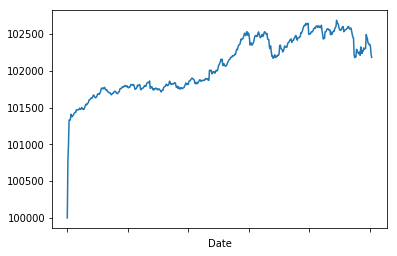

In [229]:
yield_curve = df['total_pv'].plot(x=df.index, kind='line')

In [230]:
fig = yield_curve.get_figure()
fig.savefig('yield.jpg')